In [1]:
import random
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.utils import resample
from sklearn import cluster
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split, WeightedRandomSampler
import torch

from wquantiles import quantile_1D

import matplotlib.pyplot as plt

import pdb
import os
import csv
import pickle

class ConfigStruct:
    def __init__(self, **entries):
        self.__dict__.update(entries)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [3]:
config = dict(
    epochs=100,
    batch_size=2048,
    learning_rate=0.008,
    weight_decay=1e-5,
    dropout=0.05,
    shuffle=True,
    test_size=0.2,
    split_seed=42,
    random_seed=1234,
    top10_apps_filter=False,
    only_duplicates=False,
    meancount75_filter=False,
    isolation_forest_train=False,
    isolation_forest_val=False,
    isolation_forest_test=False,
    feature_agglomeration=False,
    feature_agglomeration_nclusters=32,
    stratified_split=False,
    smooth_l1_loss_beta=1
)

In [4]:
config = ConfigStruct(**config)

In [5]:
config_string = "SpEC_sampling_no_IQR_robust_scaler_no_agglo_clustering_32_features_batchsize_2048_layers_2048-512-128"

MODEL_FILENAME = "Small_net_" + config_string
MODEL_DIR = r"../models/"
MODEL_PATH = Path(MODEL_DIR, MODEL_FILENAME).with_suffix(".tar")

DATASET_DIR = r"../data"
DATASET_NAME = "blue_waters_posix_with_paths_no_negative_outliers_no_time_witherrors"
DATASET_PATH = Path(DATASET_DIR, DATASET_NAME).with_suffix(".csv")

PICKLE_DIR = r"../models/pickle"
FEATUREAGGLO_NAME = r"blue_waters_featureagglomeration_" + config_string
FEATUREAGGLO_PATH = Path(PICKLE_DIR, FEATUREAGGLO_NAME).with_suffix(".pkl")

ROBUSTSCALER_NAME = r"blue_waters_robustscaler_" + config_string
ROBUSTSCALER_PATH = Path(PICKLE_DIR, ROBUSTSCALER_NAME).with_suffix(".pkl")

ISOLATIONFOREST_NAME = r"blue_waters_isolationforest_" + config_string
ISOLATIONFOREST_PATH = Path(PICKLE_DIR, ISOLATIONFOREST_NAME).with_suffix(".pkl")

INTERPRETABILITY_DIR = r"../interpretability/captum"

CSV_LOG_PATH = "Train_Full_Dataset_Voss_Model_C_test_loss.csv"

In [6]:
if not os.path.exists(CSV_LOG_PATH):
    with open(CSV_LOG_PATH, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["epoch", "test_loss"])

In [7]:
# Load the data
df_blue_waters_posix = pd.read_csv(DATASET_PATH)
df_blue_waters_posix.pop("path")
df_blue_waters_posix.head()

,index,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,...,WRITE_10M_100M,WRITE_100M_1G,WRITE_1G_PLUS,rank,POSIX_TOTAL_TIME,nprocs,exe,lustre,error,mean
0,0,1280,-1281,-1281,1807,0,0,2561,0,0,...,0,0,0,184,0.970498,213,./Hsigma,1,0.190429,0.780068
1,1,168420,-5232,-5232,7505724,5401751,11345341,394840,0,1,...,0,0,0,0,147.540409,80,./SpEC,1,0.000000,NaN
2,2,62567,-1477,-1477,2300215,441912,1214829,280660,0,1,...,0,0,0,-1,24.994056,48,./SpEC,1,0.000000,NaN
3,3,2366,-2367,-2367,3342,0,0,4733,0,0,...,0,0,0,127,0.487127,394,./Hsigma,1,-0.104674,0.591801
4,4,8709,-288,-288,1521073,6331589,2013343,28430,0,0,...,0,0,0,-1,14389.735087,256,CCTM_v52_Linux2_x86_64intel,1,0.000000,NaN


In [8]:
filter_spec = (df_blue_waters_posix.exe.str.strip().isin(["SpEC", "./SpEC"]))  # | (df_blue_waters_posix.POSIX_TOTAL_TIME >= 1e8)
df_blue_waters_posix_nospec = df_blue_waters_posix[filter_spec == False]
df_blue_waters_posix_nospec.shape

(479858, 95)

In [9]:
# Randomly sample 50000 benchmark runs out of 326799 and recombine the dataframes
df_blue_waters_posix_spec = df_blue_waters_posix[filter_spec]
df_blue_waters_posix_spec = resample(df_blue_waters_posix_spec, n_samples=50000, random_state=0)
df_blue_waters_posix_spec.shape

(50000, 95)

In [10]:
df_blue_waters_posix = pd.concat([df_blue_waters_posix_nospec, df_blue_waters_posix_spec])
df_blue_waters_posix.shape

(529858, 95)

In [11]:
if config.top10_apps_filter:
    apps_count_series = df_blue_waters_posix.groupby(by=["exe"]).count()["nprocs"].sort_values(ascending=False)
    df_blue_waters_posix = df_blue_waters_posix[df_blue_waters_posix.exe.isin(apps_count_series[0:10].index)]

In [12]:
if config.only_duplicates:
    df_blue_waters_posix = df_blue_waters_posix[df_blue_waters_posix["mean"].isna() == False]

In [13]:
if config.meancount75_filter:
    mean_counts = df_blue_waters_posix.groupby("mean",dropna=False)["mean"].transform("count")
    mean_counts_quantile = pd.Series(mean_counts.unique()).quantile(0.75)
    df_blue_waters_posix = df_blue_waters_posix[df_blue_waters_posix.index.isin(mean_counts[mean_counts > mean_counts_quantile].index)]

In [14]:
# Drop column with application names
df_blue_waters_posix = df_blue_waters_posix.drop(['exe'], axis=1)
df_blue_waters_posix.head()

,index,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,...,WRITE_4M_10M,WRITE_10M_100M,WRITE_100M_1G,WRITE_1G_PLUS,rank,POSIX_TOTAL_TIME,nprocs,lustre,error,mean
0,0,1280,-1281,-1281,1807,0,0,2561,0,0,...,0,0,0,0,184,0.970498,213,1,0.190429,0.780068
3,3,2366,-2367,-2367,3342,0,0,4733,0,0,...,0,0,0,0,127,0.487127,394,1,-0.104674,0.591801
4,4,8709,-288,-288,1521073,6331589,2013343,28430,0,0,...,0,0,0,0,-1,14389.735087,256,1,0.000000,NaN
5,5,8709,-288,-288,1516465,8334307,2006943,28430,0,0,...,0,0,0,0,-1,14340.456718,256,1,0.000000,NaN
6,6,8709,-288,-288,1511857,13971437,2006175,28430,0,0,...,0,0,0,0,-1,15207.986212,256,1,0.000000,NaN


In [15]:
# Separate bandwidth from input features
POSIX_TOTAL_TIME_df = df_blue_waters_posix.pop('POSIX_TOTAL_TIME')
POSIX_TOTAL_TIME_df.head()

0        0.970498
3        0.487127
4    14389.735087
5    14340.456718
6    15207.986212
Name: POSIX_TOTAL_TIME, dtype: float64

In [16]:
# Separate duplicate set mean from input features and drop errors
dup_set_means_df = df_blue_waters_posix.pop('mean')

In [17]:
df_blue_waters_posix = df_blue_waters_posix.drop(["error"], axis=1)
df_blue_waters_posix.head()

,index,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,...,WRITE_10K_100K,WRITE_100K_1M,WRITE_1M_4M,WRITE_4M_10M,WRITE_10M_100M,WRITE_100M_1G,WRITE_1G_PLUS,rank,nprocs,lustre
0,0,1280,-1281,-1281,1807,0,0,2561,0,0,...,0,0,0,0,0,0,0,184,213,1
3,3,2366,-2367,-2367,3342,0,0,4733,0,0,...,0,0,0,0,0,0,0,127,394,1
4,4,8709,-288,-288,1521073,6331589,2013343,28430,0,0,...,9,25830,756,0,0,0,0,-1,256,1
5,5,8709,-288,-288,1516465,8334307,2006943,28430,0,0,...,9,25830,756,0,0,0,0,-1,256,1
6,6,8709,-288,-288,1511857,13971437,2006175,28430,0,0,...,9,25830,756,0,0,0,0,-1,256,1


In [18]:
# Fix seeds for reproducibility
random.seed(config.random_seed)
np.random.seed(config.random_seed)

torch.manual_seed(config.random_seed)
torch.cuda.manual_seed_all(config.random_seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [19]:
# Split the data
X_train, X_test, y_train, y_test, dup_set_means_train, dup_set_means_test = train_test_split(df_blue_waters_posix,
                                                    POSIX_TOTAL_TIME_df,
                                                    dup_set_means_df,
                                                    test_size=config.test_size,
                                                    random_state=config.split_seed,
                                                    stratify=df_blue_waters_posix["nprocs"] if config.stratified_split else None)

In [20]:
X_train_subset, X_val_subset, y_train_subset, y_val_subset, dup_set_means_train_subset, dup_set_means_val_subset = train_test_split(X_train,
                                                    y_train,
                                                    dup_set_means_train,
                                                    train_size=0.8,
                                                    random_state=config.split_seed)

In [21]:
clf = IsolationForest(random_state=0, n_jobs=-1)
clf.fit(X_train_subset)

IsolationForest(n_jobs=-1, random_state=0)

In [22]:
with open(ISOLATIONFOREST_PATH,'wb') as f:
    pickle.dump(clf,f)

In [23]:
X_train_subset_outlier_labels = pd.Series(clf.predict(X_train_subset))
X_val_subset_outlier_labels = pd.Series(clf.predict(X_val_subset))
X_test_outlier_labels = pd.Series(clf.predict(X_test))

In [24]:
if config.isolation_forest_train:
    X_train_subset = X_train_subset.reset_index()[X_train_subset_outlier_labels == 1].drop(["index"], axis=1)
    y_train_subset = y_train_subset.reset_index()[X_train_subset_outlier_labels == 1].drop(["index"], axis=1)
    dup_set_means_train_subset = dup_set_means_train_subset.reset_index()[X_train_subset_outlier_labels == 1].drop(["index"], axis=1)

In [25]:
if config.isolation_forest_val:
    X_val_subset = X_val_subset.reset_index()[X_val_subset_outlier_labels == 1].drop(["index"],axis=1)
    y_val_subset = y_val_subset.reset_index()[X_val_subset_outlier_labels == 1].drop(["index"],axis=1)

In [26]:
if config.isolation_forest_test:
    X_test = X_test.reset_index()[X_test_outlier_labels == 1].drop(["index"],axis=1)
    y_test = y_test.reset_index()[X_test_outlier_labels == 1].drop(["index"],axis=1)
    dup_set_means_test = dup_set_means_test.reset_index()[X_test_outlier_labels == 1].drop(["index"],axis=1)

In [27]:
# Compute counts for weighted random sampler as 1/duplicate_set_size
dup_set_means_train_subset_df = pd.DataFrame(dup_set_means_train_subset)
mean_counts = dup_set_means_train_subset_df.groupby("mean",dropna=False)["mean"].transform("count")
mean_counts.loc[mean_counts == 0] = 1
weights = 1 / mean_counts
weights.head()

713822    1.000000
213132    1.000000
473941    1.000000
120787    0.142857
680929    1.000000
Name: mean, dtype: float64

In [28]:
generator = torch.Generator().manual_seed(config.random_seed)
sampler = WeightedRandomSampler(weights.to_numpy(), len(weights), replacement=True, generator=generator)

In [29]:
# Save the test dataset for later analysis with captum
# test_df = X_test.copy()
# test_df["POSIX_TOTAL_TIME"] = y_test
# test_df = test_df.reset_index()[X_test_outlier_labels == -1].drop(["index"],axis=1)
# test_df.to_csv(Path(MODEL_DIR,r"captum_test_data.csv"))
# test_df.to_csv(Path(MODEL_DIR,r"test_outliers_index_reset.csv"))

In [30]:
agglo = cluster.FeatureAgglomeration(n_clusters=config.feature_agglomeration_nclusters)
agglo.fit(df_blue_waters_posix)
with open(FEATUREAGGLO_PATH,'wb') as f:
    pickle.dump(agglo,f)

In [31]:
if config.feature_agglomeration:
    X_train_subset = agglo.transform(X_train_subset)
    X_val_subset = agglo.transform(X_val_subset)
    X_test = agglo.transform(X_test) 

In [32]:
# Save the test dataset for later analysis with captum
test_df = X_test.copy()
test_df["POSIX_TOTAL_TIME"] = y_test
test_df = test_df.reset_index()
test_df.to_csv(Path(INTERPRETABILITY_DIR, r"captum_Model_C_test_data.csv"))

In [33]:
# Scale the input features with RobustScaler
scaler = RobustScaler().fit(X_train_subset)

In [34]:
with open(ROBUSTSCALER_PATH, 'wb') as f:
    pickle.dump(scaler, f)

In [35]:
X_train_subset_scaled = scaler.transform(X_train_subset)
X_val_subset_scaled = scaler.transform(X_val_subset)

In [36]:
tensor_X_train = torch.Tensor(X_train_subset_scaled).to(device)
tensor_y_train = torch.Tensor(y_train_subset.values).view(-1, 1).to(device)

In [37]:
training_dataset = TensorDataset(tensor_X_train, tensor_y_train)

In [38]:
# If shuffle disabled, use weighted random sampling
if config.shuffle:
    training_dataloader = DataLoader(training_dataset, batch_size=config.batch_size, shuffle=config.shuffle)
else:
    training_dataloader = DataLoader(training_dataset, batch_size=config.batch_size, sampler=sampler)

In [39]:
tensor_X_val = torch.Tensor(X_val_subset_scaled).to(device)
tensor_y_val = torch.Tensor(y_val_subset.values).view(-1, 1).to(device)

In [40]:
validation_dataset = TensorDataset(tensor_X_val, tensor_y_val)
validation_dataloader = DataLoader(validation_dataset, batch_size=config.batch_size)  #, shuffle=config.shuffle)

In [41]:
X_test_scaled = scaler.transform(X_test)

In [42]:
tensor_X_test = torch.Tensor(X_test_scaled).to(device)
tensor_y_test = torch.Tensor(y_test.values).view(-1, 1).to(device)

In [43]:
test_dataset = TensorDataset(tensor_X_test, tensor_y_test)
test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size)

In [44]:
model = nn.Sequential(
    nn.Linear(config.feature_agglomeration_nclusters if config.feature_agglomeration else 91, 2048),
    nn.Dropout(p=config.dropout),
    nn.ReLU(),
    nn.Linear(2048, 512),
    nn.Dropout(p=config.dropout),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.Dropout(p=config.dropout),
    nn.ReLU(),
    nn.Linear(128, 1)
).to(device)

In [45]:
# By default Pytorch returns avg loss per minibatch elements. But since the last batch
# (both in training and test) does not have enough instances, sum all the loss across the batches
# and then divide it by total number of elements in the the test set.
loss_fn = nn.SmoothL1Loss(beta=config.smooth_l1_loss_beta, reduction="sum").to(device)

optimizer = optim.Adamax(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

In [46]:
model_epoch = 0
model.train()

Sequential(
  (0): Linear(in_features=91, out_features=2048, bias=True)
  (1): Dropout(p=0.05, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=2048, out_features=512, bias=True)
  (4): Dropout(p=0.05, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=128, bias=True)
  (7): Dropout(p=0.05, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=1, bias=True)
)

In [47]:
def train():
    for (X, y) in training_dataloader:
        y_pred = model(X)
        
        # Divide the summed loss by the number of elements in the current batch to get the average loss
        loss = loss_fn(y, y_pred) / len(X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.train()

In [48]:
def test():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in validation_dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item() 

    # Divide the summed test loss by the number of elements in the whole test dataset to get the average loss
    test_loss /= len(validation_dataloader.dataset)

    # print(f"Avg loss: {test_loss:>8f} \n")

    return test_loss

In [49]:
test_losses = []

for epoch in range(model_epoch, config.epochs):
    # print(f"Epoch {epoch + 1}\n-------------------------------")
    train()
    test_loss = test()
    
    scheduler.step(test_loss)

    model_epoch = epoch
    test_losses.append(test_loss)

    with open(CSV_LOG_PATH, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch + 1, test_loss])

    torch.save({
        'epoch': model_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'test_losses': test_losses
    }, MODEL_PATH)

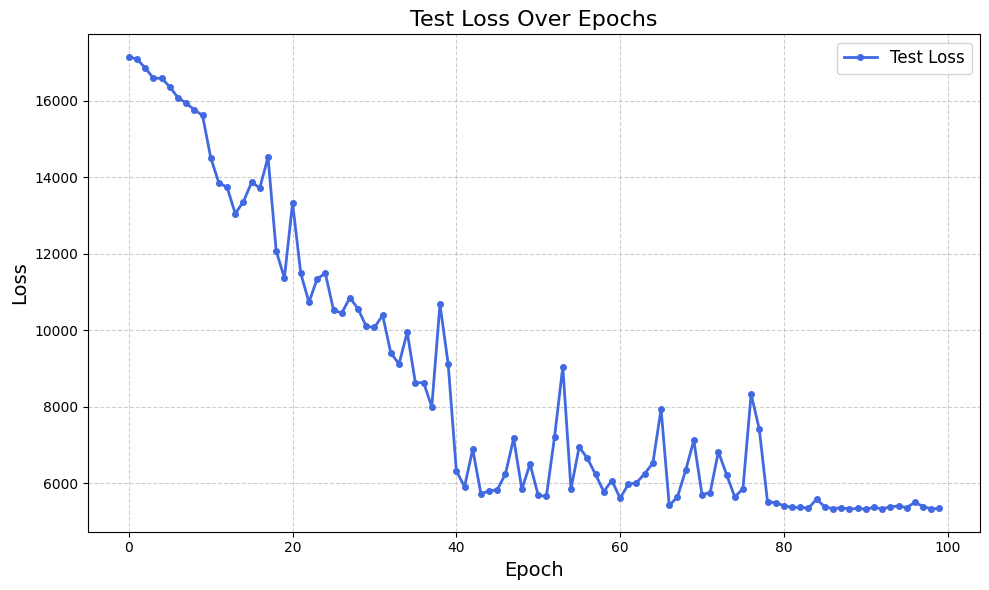

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(test_losses, label='Test Loss', color='royalblue', linewidth=2, marker='o', markersize=4)

plt.title("Test Loss Over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [51]:
test_output_tensor = torch.Tensor([]).to(device)
with torch.no_grad():
    for X,y in test_dataloader:
        output = model(X)
        output_as_tensor = torch.Tensor(output).to(device)
        test_output_tensor = torch.cat((test_output_tensor,output_as_tensor))
test_output_df = pd.DataFrame(test_output_tensor.cpu().numpy())
test_output_df

,0
0,0.515778
1,15863.186523
2,0.507818
3,9.028156
4,6.614722
...,...
105967,0.521648
105968,0.519017
105969,6.491106
105970,15932.221680


In [52]:
abs_errors = (test_output_df[0] - dup_set_means_test.fillna(0).reset_index()["mean"]).abs()
abs_errors

0             0.515778
1         15863.186523
2             0.507818
3             4.632766
4             2.119187
              ...     
105967        0.645546
105968        0.519017
105969        0.479204
105970    15932.221680
105971        0.517943
Length: 105972, dtype: float64

In [53]:
# Division result will be NaN where the mean is NaN because the set has no duplicates. Median ignores NaN
abs_errors_percent = (abs_errors / dup_set_means_test.reset_index()["mean"])
abs_errors_percent

0              NaN
1              NaN
2              NaN
3         1.054006
4         0.242639
            ...   
105967    0.553075
105968         NaN
105969    0.068749
105970         NaN
105971    0.383022
Length: 105972, dtype: float64

In [54]:
mae = abs_errors_percent.median()
print(f"MAE: {mae}")

MAE: 0.15557677479311446


In [55]:
dup_set_means_test_df = pd.DataFrame(dup_set_means_test)
mean_counts_test = dup_set_means_test_df.groupby("mean",dropna=False)["mean"].transform("count")
mean_counts_test.loc[mean_counts_test == 0] = 1
weights_test = 1 / mean_counts_test
weights_test.loc[mean_counts_test < 1] = weights_test.loc[mean_counts_test < 1]   
weights_test_nona = weights_test.reset_index()[abs_errors_percent.isna() == False].drop(["index"],axis=1)["mean"]
weights_test_nona_normalized = weights_test_nona / weights_test_nona.sum()
weighted_mae = quantile_1D(abs_errors_percent[abs_errors_percent.isna() == False].to_numpy().T,weights_test_nona_normalized.to_numpy().T,0.5)
print(f"Weighted MAE: {weighted_mae}")

Weighted MAE: 0.1538600430826033


In [56]:
test_outliers = len(X_test_outlier_labels[(X_test_outlier_labels == -1) & (dup_set_means_test.reset_index()["mean"].notnull())])
print(f"Outliers in test set that are considered in MAE computation: {test_outliers}")
print(f"Feature Agglomeration clusters: {agglo.labels_}")

Outliers in test set that are considered in MAE computation: 192
Feature Agglomeration clusters: [ 0  0  0  0 28  1 24  0  0  0  0  0  0 19 21 31 17 30 15 22  1  0  0  0
 20 29 25 27  0 10  4  0  0  0  0  0  0  0  2  5  6  0  0  0  0  0  0  0
 16 13 23 11  0  0  0  0 26  9  7 18 12 14  0  0  0  8  0  3  0 10  4  0
  0  0  0  0  0  0  2  5  6  0  0  0  0  0  0  0  0  0  0]
